In [1]:
import sys
import os
sys.path.append(os.path.abspath("./MLP"))
sys.path.append(os.path.abspath("./datasets"))
sys.path.append(os.path.abspath("./KAN"))
from MLP import MLP
from MLPWrapper import MLPWrapper
from convert_data_to_input import CreateInput
from KAN import KANWrapper
from KAN_model import KANModel
import torch
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neural_network,pipeline,preprocessing,linear_model
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Prepare data

In [ ]:
# get input data
deepmimo = True

function_folder = "seq_sin_gaussian_-16.28"

data = CreateInput(function_folder, deepmimo)

tensors = data.get_tensors()

            0         1         2         3         4         5         6  \
0    0.427601  0.607306 -0.321090 -0.512502  0.629511 -1.657273 -0.836790   
1    0.162546 -1.522824 -1.102106 -1.323994 -1.043721  0.548376  0.036431   
2   -0.623237 -0.127901  0.063730 -1.468646  0.409466 -0.768695  1.296753   
3   -0.042409  0.061870 -0.418647 -0.119284 -0.562029 -0.683403  1.111804   
4   -0.510894 -0.500043 -1.844083 -1.081082 -1.644902  0.050343 -0.083130   
..        ...       ...       ...       ...       ...       ...       ...   
695 -0.030295 -0.377192  0.647447  0.224012 -0.737165  0.454133 -0.217371   
696  0.314378  0.329309  1.417906 -0.470165 -0.612540  0.115256 -0.702301   
697 -0.186013  0.204419 -0.770054 -1.703340  0.002606  0.900155  0.428768   
698 -0.117785  0.440072  0.776910 -0.302358 -1.107743 -0.073842 -1.155031   
699  2.131195 -1.012398 -0.878012 -0.603724 -0.595628 -0.773261  0.597919   

            7         8         9  ...        20        21        22  \
0  

In [3]:
print(type(data))

<class 'convert_data_to_input.CreateInput'>


In [4]:
tensors['test'][1].shape

torch.Size([200, 30])

# Evaluate KAN

In [5]:
# find optimal params for KAN

kan_wrapper = KANWrapper(data=tensors,deepmimo=deepmimo)
input_size = tensors['test'][1].shape[1]

if deepmimo:
    param_grid = {
        'kan__data': [tensors],
        'kan__width': [[input_size, 2*input_size + 1, input_size],
                       [input_size, 20, input_size], [input_size, 20, 20, input_size], [input_size, 20, 20, 20, input_size],
                       [input_size, 10, input_size],
                       [input_size, 5, input_size],
                       [input_size, 20, 10, 20, input_size], [input_size, 10, 5, 10, input_size]], 
        'kan__grid': [3, 5],
        'kan__k': [3, 5],
        'kan__seed': [42],
        'kan__lr': [0.01],
        'kan__lamb': [0],
        'kan__deepmimo': [True],
        'kan__epochs': [10]
    }

else:
    param_grid = {
        'kan__data': [tensors],
        'kan__width': [[1, 3, 1], [1, 3, 3, 1], [1, 3, 3, 3, 1], [1, 3, 1], [1, 5, 5, 1], [1, 5, 5, 5, 1], [1, 7, 1], [1, 7, 7, 1], [1, 7, 7, 7, 1]],
        'kan__grid': [3],
        'kan__k': [5],
        'kan__seed': [42],
        'kan__lr': [0.001, 0.0001],
        'kan__lamb': [0],
        'kan__deepmimo': [False],
        'kan__epochs': [20]
    }


# (Optional) Create a pipeline if preprocessing is needed
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kan', kan_wrapper)
])

# Initialize RandomizedSearchCV
"""grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=5,                           # Number of parameter settings sampled
    cv=5,                                  # 5-Fold Cross-Validation
    scoring='neg_mean_squared_error',  # Appropriate for regression
    random_state=42,                    # For reproducibility
    n_jobs=-1,                          # Utilize all CPU cores
    verbose=1
)"""
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,                                  # 5-Fold Cross-Validation
    scoring='neg_mean_squared_error',  # Appropriate for regression
    n_jobs=-1,                          # Utilize all CPU cores
    verbose=1
)
# Fit RandomizedSearchCV
grid_search.fit(kan_wrapper.X_train, kan_wrapper.y_train)

# Retrieve the best parameters and best score
grid_search.best_params_['kan__data'] = []          # remove annoying print
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

opt_params_KAN = grid_search.best_params_


Fitting 5 folds for each of 32 candidates, totalling 160 fits


| train_loss: 2.97e-03 | test_loss: 1.26e-02 | reg: 2.93e+01 | : 100%|█| 10/10 [00:09<00:00,  1.04it
| train_loss: 2.84e-03 | test_loss: 1.25e-02 | reg: 2.95e+01 | : 100%|█| 10/10 [00:09<00:00,  1.03it
| train_loss: 2.16e-03 | test_loss: 1.25e-02 | reg: 2.84e+01 | : 100%|█| 10/10 [00:09<00:00,  1.02it
| train_loss: 3.09e-03 | test_loss: 1.40e-02 | reg: 2.96e+01 | : 100%|█| 10/10 [00:09<00:00,  1.02it
| train_loss: 2.71e-03 | test_loss: 1.15e-02 | reg: 2.91e+01 | : 100%|█| 10/10 [00:09<00:00,  1.02it
| train_loss: 1.66e-03 | test_loss: 1.14e-02 | reg: 6.75e+01 | : 100%|█| 10/10 [00:14<00:00,  1.40s/
| train_loss: 1.81e-03 | test_loss: 1.09e-02 | reg: 6.90e+01 | : 100%|█| 10/10 [00:14<00:00,  1.42s/
| train_loss: 1.64e-03 | test_loss: 9.06e-03 | reg: 6.79e+01 | : 100%|█| 10/10 [00:16<00:00,  1.62s/
| train_loss: 1.76e-03 | test_loss: 9.46e-03 | reg: 6.68e+01 | : 100%|█| 10/10 [00:16<00:00,  1.61s/
| train_loss: 1.83e-03 | test_loss: 1.50e-02 | reg: 6.83e+01 | : 100%|█| 10/10 [00:16<00:00

Best Parameters: {'kan__data': [], 'kan__deepmimo': True, 'kan__epochs': 10, 'kan__grid': 3, 'kan__k': 3, 'kan__lamb': 0, 'kan__lr': 0.01, 'kan__seed': 42, 'kan__width': [[30, 0], [10, 0], [5, 0], [10, 0], [30, 0]]}
Best Cross-Validation Score: -1.3198476835896145e-05


In [6]:
# evaluate KAN with optimal params
kan_model = KANModel(width=opt_params_KAN['kan__width'], grid=opt_params_KAN['kan__grid'], k=opt_params_KAN['kan__k'], seed=opt_params_KAN['kan__seed'], lr=opt_params_KAN['kan__lr'], lamb=opt_params_KAN['kan__lamb'], deepmimo=deepmimo, epochs=30, results_path=f'results/KAN/{function_folder}')
kan_model.load_data(tensors)
loss_data, time_elapsed = kan_model.fit()
y_preds = kan_model.predict()


checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                           | 0/30 [00:00<?, ?it/s]

| train_loss: 1.21e-04 | test_loss: 2.32e-03 | reg: 4.62e+01 | : 100%|█| 30/30 [00:12<00:00,  2.48it

saving model version 0.1


In [7]:
"""print(y_preds['preds'][0].shape)
x=np.linspace(-10, 10, 20)
many_x = np.linspace(-10, 10, 200)
plt.plot(x, y_preds['preds'][0], "o")
plt.plot(many_x, np.sin(many_x))
plt.plot(x, tensors['train'][0][0], ".")
plt.show()"""

'print(y_preds[\'preds\'][0].shape)\nx=np.linspace(-10, 10, 20)\nmany_x = np.linspace(-10, 10, 200)\nplt.plot(x, y_preds[\'preds\'][0], "o")\nplt.plot(many_x, np.sin(many_x))\nplt.plot(x, tensors[\'train\'][0][0], ".")\nplt.show()'

In [8]:
"""if deepmimo:
    kan_model = KANModel(width=[20, 10,10, 20], grid=20, k=3, seed=42, lr=0.1, lamb=0,deepmimo=deepmimo,steps=10)
    kan_model.load_data(tensors)
    loss_data, time_elapsed = kan_model.fit()
    y_preds = kan_model.predict()"""

'if deepmimo:\n    kan_model = KANModel(width=[20, 10,10, 20], grid=20, k=3, seed=42, lr=0.1, lamb=0,deepmimo=deepmimo,steps=10)\n    kan_model.load_data(tensors)\n    loss_data, time_elapsed = kan_model.fit()\n    y_preds = kan_model.predict()'

torch.Size([30])
30


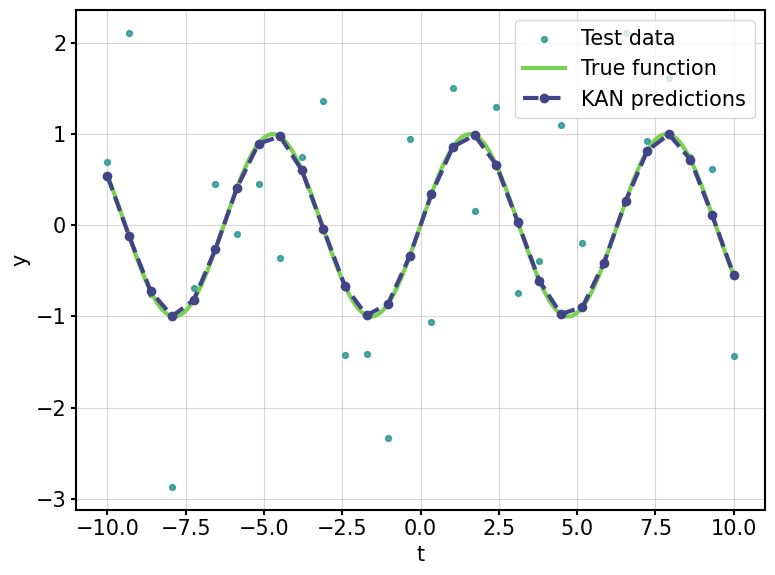

In [9]:
# plot pred and true
if deepmimo:
    #kan_model.plot_deepmimo(data=tensors, y_preds=y_preds['preds'], type_='test', save=False)
    kan_model.plot_sequence(data=tensors, y_preds=y_preds['preds'], type_='test', save=True)
else:
    kan_model.plot_prediction(data=tensors, y_preds=y_preds['preds'], type_='test', save=True)

In [10]:
# plot noise and true
# if deepmimo:
#     kan_model.plot_deepmimo(data=tensors, y_preds=tensors['test'][0][:2,:], type_='test', save=False)

In [11]:
# diffrence in noise and true
#torch.sum(np.abs(tensors['test'][0][:1,:] - tensors['test'][1][:1,:]))

In [12]:
# diffrence pred and true
#torch.sum(np.abs(y_preds['preds'][0] - tensors['test'][1][:1,:]))

saved loss to  results/KAN/seq_sin_gaussian_-2.27/loss.png
Model parameters saved to results/KAN/seq_sin_gaussian_-2.27/model_params.txt


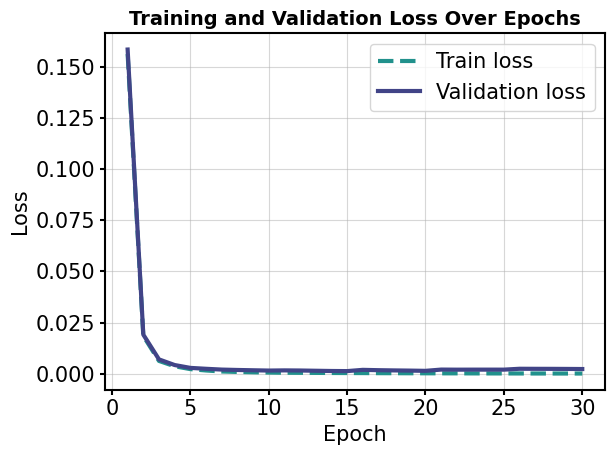

In [13]:
# plot loss
kan_model.plot_loss(loss_data=loss_data, save=True)

In [14]:
# Test loss
print(y_preds['test_loss'])

tensor(0.0143)


# Evaluate MLP

In [15]:
# find optimal params for mlp
mlp_wrapper = MLPWrapper(data=tensors,deepmimo=deepmimo)

if deepmimo:
    param_grid = {
        'mlp__data': [tensors],
        'mlp__input_size': [input_size],
        'mlp__hidden_size': [[2*input_size + 1],
                       [20], [20, 20], [20, 20, 20],
                       [10],
                       [5],
                       [20, 10, 20], [10, 5, 10]],
        'mlp__output_size': [input_size],
        'mlp__epochs': [10],
        'mlp__deepmimo': [True],
        'mlp__lr': [0.01]
    }

else:
    param_grid = {
        'mlp__data': [tensors],
        'mlp__input_size': [1],
        'mlp__hidden_size': [[3], [3, 3], [3, 3, 3], [5], [5, 5], [5, 5, 5], [7], [7, 7], [7, 7, 7]],
        'mlp__output_size': [1],
        'mlp__epochs': [20, 21],
        'mlp__deepmimo': [False],
        'mlp__lr': [0.001]
    }


# (Optional) Create a pipeline if preprocessing is needed
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Example preprocessor
    ('mlp', mlp_wrapper)
])

# Initialize RandomizedSearchCV
"""grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=5,  # Number of parameter settings sampled
    cv=5,        # 5-Fold Cross-Validation
    scoring='neg_mean_squared_error',  # Appropriate for regression
    random_state=42,                    # For reproducibility
    n_jobs=-1,                          # Utilize all CPU cores
    verbose=0
)"""

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,                                  # 5-Fold Cross-Validation
    scoring='neg_mean_squared_error',  # Appropriate for regression
    n_jobs=-1,                          # Utilize all CPU cores
    verbose=1
)

# Fit RandomizedSearchCV
grid_search.fit(mlp_wrapper.X_train, mlp_wrapper.y_train)

# Retrieve the best parameters and best score
grid_search.best_params_['mlp__data'] = []          # remove annoying print
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

opt_params_MLP = grid_search.best_params_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/Users/zeshenbao/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
  0%|          | 0/10 [00:00<?, ?it/s]/Users/zeshenbao/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
  0%|          | 0/10 [00:00<?, ?it/s]/Users/zeshenbao/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
  0%|          | 0/10 [00:00<?, ?

Best Parameters: {'mlp__data': [], 'mlp__deepmimo': True, 'mlp__epochs': 10, 'mlp__hidden_size': [5], 'mlp__input_size': 30, 'mlp__lr': 0.01, 'mlp__output_size': 30}
Best Cross-Validation Score: -0.00015908554342590418


In [21]:
# evaluate KAN with optimal params
mlp_model = MLP(input_size=opt_params_MLP['mlp__input_size'], hidden_sizes=opt_params_MLP['mlp__hidden_size'], output_size=opt_params_MLP['mlp__output_size'], result_path=f'results/MLP/{function_folder}')
mlp_model.load_data(tensors, deepmimo=deepmimo)
loss_data_MLP, time_elapsed_MLP = mlp_model.fit(mlp_model.X_train, mlp_model.y_train, n_epochs=30, cross_validation=False, deepmimo=deepmimo)
y_preds_MLP = mlp_model.predict(mlp_model.X_test,eval=True)

100%|██████████| 30/30 [00:00<00:00, 57.51it/s]


torch.Size([30])
30


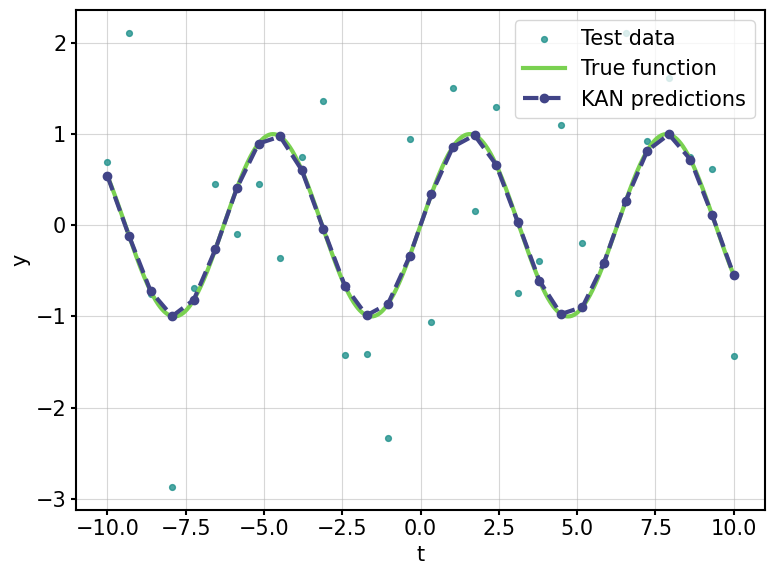

In [22]:
# plot predictions
if deepmimo:
    # mlp_model.plot_deepmimo(data=tensors, y_preds=y_preds_MLP['preds'], type_='test', save=False)
    mlp_model.plot_sequence(data=tensors, y_preds=y_preds_MLP['preds'], type_='test', save=True)
else:
    mlp_model.plot_prediction(data=tensors, y_preds=y_preds_MLP['preds'], type_='test', save=True)

saved loss to  results/MLP/seq_sin_gaussian_-2.27/loss.png
Model parameters saved to results/MLP/seq_sin_gaussian_-2.27/model_params.txt


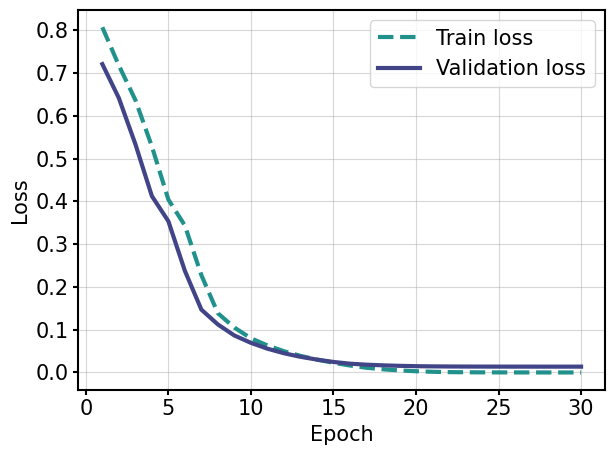

In [23]:
# plot loss

mlp_model.plot_loss(loss_data=loss_data_MLP, save=True, deepmimo=deepmimo)

In [24]:
# Test loss
print(y_preds_MLP['test_loss'])

tensor(0.0064)
